# R9. Best Practices when using the Resnick High Performance Computing Center and other related topics

*This recitation was prepared by Zachary Martinez with the help of the [Caltech HPC documentation](https://www.hpc.caltech.edu/documentation)*

This notebook covers a variety of High Performance Computing topics, specifically tailored for the Caltech HPCC. While the core concepts will apply to other computing clusters, there might be  differences in terms of job scheduling, storage practices etc.
<hr>

## What even is a supercomputer?

Essentially, supercomputers usually contain thousands of CPUs linked together to perform parallel processing for computationally intensive tasks. The supercomputers usually also have terabytes to petabytes of storage, which allow the analysis of immense quantities of data. Furthermore, supercomputers often have many GPUs to facillitate the acceleration of parallelized mathematical computations, including matrix operations for deep learning.

For example, here is an overview of the [overview](https://www.hpc.caltech.edu/resources) of the resources that the Caltech HPCC has.

Notice the "Nodes" column under Compute Nodes. The HPCC has 179 normal "Compute" nodes, which each contain 32 CPU cores. In total, all of the "Compute" nodes combined contain 5728 cores. For more special tasks, one can request to use special types of nodes including expanded memory nodes, GPU nodes and others listed above. Also, note that most supercomputers use a Linux based OS, with all HPCC nodes running CentOS Linux 7.
<hr>

## How to use the Caltech HPCC?

### Obtaining access

In order to access the HPCC, you will first require authorization. Your PI will need to have already set up a group account for the HPCC. Then, they and other group admins can add you using the management console. Once you are granted access, there are a few more steps needed to use the HPCC:

1. Set up Two-Factor authentication through [Duo](https://www.imss.caltech.edu/services/security/mfa/self-enrollment)
2. Either be using Campus Wifi or logged in through the [Caltech VPN service](https://www.imss.caltech.edu/services/wired-wireless-remote-access/Virtual-Private-Network-VPN) before logging on

### Logging on

When all of the above tasks are completed, you should be able to use the HPCC through a variety of ways. The simplest and my preferred method is through a terminal on my personal computer. You can SSH into the HPCC by using the following command:
```
$ ssh zmartine@login.hpc.caltech.edu
```

You will then be prompted to provide your Caltech password and then perform the Two-Factor authentication through Duo. If you receive:
```
ssh: connect to host login.hpc.caltech.edu port 22: Connection refused
```

then this usually means that you are not using the Caltech Wifi or VPN.

When you are able to connect through the terminal, you will land on one of the 2 Login nodes. **These nodes are strictly for compiling software and submitting jobs to run on the HPCC using SLURM. Don't run compute heavy tasks!**

If you don't like using the terminal, you can use [Open OnDemand](https://interactive.hpc.caltech.edu/). This method allows you to use your internet browser to manage your files, view your active jobs, and use Jupyter Lab, R Studio, MATLAB and even a virtual desktop. I prefer using Jupyter Lab with the HPCC to compose and test new scripts/functions, especially when I require GPU access.

### SLURM

Simple Linux Utility for Resource Management (SLURM) is an open-source job scheduler that is used by many clusters and supercomputers. Due to the fact that there is a limited amount of resources available to use on the HPCC, users must submit their jobs and essentially wait in line for available compute. SLURM allocates access to the different nodes based on availability and the resources requested. Due to the fact that the queue time increases with the more resources requested while execution time usually decreases, users must conduct scaling analysis to optimize "time to solution". Pictured below is a graphical representation of this concept, from Princeton Research Computing. 

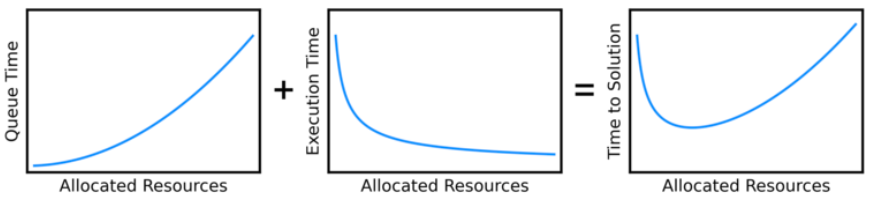

Below is an example of a SLURM job submission script "my_slurm_script.slurm":
```shell
#!/bin/bash

#SBATCH --time=8:00:00   # requested walltime
#SBATCH --ntasks=32   # number of processor cores
#SBATCH --nodes=1   # number of nodes
#SBATCH --mem-per-cpu=16G   # memory per CPU core
#SBATCH -J "My_First_Job"   # job name
#SBATCH --mail-user=zmartine@caltech.edu   # email address
#SBATCH --mail-type=BEGIN   # email you when job begins
#SBATCH --mail-type=END   # email you when job ends
#SBATCH --mail-type=FAIL   # email you when job fails

module purge   # removes any previously loaded packages
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/central/groups/mthomson/zam/miniconda3/lib   # use my miniconda library
conda activate example_env   # activate my conda environment to load packages to run the script

python3 highly_parallelized_script.py   # command that the HPCC will run
```
This job would be submitted by first accessing a login node, changing your directory to where the SLURM script is located and then submitting the job with:
```
$ sbatch my_slurm_script.slurm
```
Once the job begins, "My_First_Job_xxxxxx.out" in whatever directory you submitted the job in will contain the stdout and stderr from your job.

There are a variety of different configurations you can request and I definitely recommend checking out [SLURMs cheatsheet](https://slurm.schedmd.com/pdfs/summary.pdf) for more commands. Some other commonly used flags include:
- --gres=gpu:x
    - Requests x GPUs, max of 4 per node on the HPCC
- --qos debug    
    - Gives job higher priority
    - Limits include 30 min run time, 2 nodes and maximum of 2 debug jobs per user
    - Great for debugging scripts without having to wait forever
- --constraint=cascadelake    
    - Requests to only use cascadelake nodes

Caltech also offers a [SLURM Script Generator](https://s3-us-west-2.amazonaws.com/imss-hpc/index.html) which creates SLURM scripts with your desired configuration.

Other useful SLURM commands include:
- squeue -u zmartine
    - Shows your pending and running jobs
- scancel 12345678
    - Kills job with specified jobid that you can obtain through squeue
    
If you wanted to interactively use compute nodes without submitting a batch job, you can request access with:
```
$ srun --nodes=1 --time=01:00:00 --ntasks-per-node=4 --pty bash -i
```
This will give you access to one compute node for 1 hours with 4 cores. You can then use: 
```
$ squeue -u zmartine
```
to check which compute node you were assigned. You can then connect to that node with:
```
$ ssh hpc-xx-xx
```

Lastly, there are a variety of SLURM environmental variables you can use in your scripts, which can allow you to programatically extract information such as Job ID, cores requested, list of nodes assigned etc. These can be accessed through various ways, including bash:
```shell
echo $SLURM_NTASKS
```
or python:
```python
import os
n_tasks = os.environ['SLURM_NTASKS']
```

### Transferring files

When using the HPCC, there are many reasons why you might need to transfer files to and from the cluster. Here are a few different ways. More info can be found at the Caltech HPCC page for [transferring files](https://www.hpc.caltech.edu/documentation/transferring-files)
- [Open OnDemand](https://interactive.hpc.caltech.edu/) which provides a GUI
- Software such as WinSCP, FileZilla, Cyberduck etc.
- SCP
- Amazon S3 using awscli

My preferred way is using SCP, which allows me to programatically move files back and forth from the command line.

To copy files to the HPCC in your directory remote_scripts:
```
$ scp local_scripts/local_filename.py zmartine@login.hpc.caltech.edu:/home/zmartine/remote_scripts/
```
To copy files from the HPCC to your currect working directory on your local machine:
```
$ scp zmartine@login.hpc.caltech.edu:/home/zmartine/remote_scripts/remote_filename.py .
```

### Storage
There are 3ish different storage spaces:
- User
    - 50GB in your home directory
- Group
    - Each group has a default of 10TB of storage, but this can be increased. For example, Thomson Lab has 80TB
- Scratch
    - There are technically two scratch storage spaces, /central/scratch (20TB per user) and /central/scratchio (2TB per user). The latter space specializes in faster file operations, so it would be wise to profile your scripts to see which space is more efficient. Keep in mind, files not accessed in 14 days will automatically be purged, which is the reason these are scratch spaces

You can check your personal storage quota with:
```
$ mmlsquota -u zmartine --block-size auto central:home
```
and your groups quota:
```
$ mmlsquota -j mthomson --block-size auto central
```

Lastly, it is pretty easy to fill up your 50GB home storage quota. Because of this, I recommend installing your conda environments into your group directory. A variety of weird errors can arise from running out of storage, so definitely keep an eye on your quota!

### Software
A variety of software has been pre-installed on the HPCC. Sometimes installing software on computing clusters can be *very* challenging, so make sure to check and see if your desired software is already available. These can be used through the modules environment management system. To see what software is available, you can use the command:
```
$ module avail
```
If you wanted to load software, such as Singularity:
```
$ module load singularity/3.8.0
```
To remove all loaded modules:
```
$ module purge
```

### Support
An easy way to get help is by submitting a [help ticket](https://help.caltech.edu/helpdesk/WebObjects/Helpdesk.woa). Don't forget to read through the HPCC documentation before submitting a ticket, because you might find your answer more quickly.

### Pro-Tip for writing code on the HPCC
I personally use VSCode as my code editor. A great feature of VSCode is the ability to SSH into the HPCC and create/edit/view files on the cluster. This greatly speeds up my workflow and gives me access to all the great VSCode plugins. An alternative is VIM, which while useful, is not the most user-friendly nor feature rich. I'm sure VSCode isn't the only editor to have this feature, but it is the only one I've used so far.
<hr>

## Concurrency with Python
*This section was written with the help of geeksforgeeks.org, realpython.com and superfastpython.org*

```
 “Premature optimization is the root of all evil (or at least most of it) in programming.”
     - Donald Knuth
```

While there are different ways to speed up Python scripts, I will be focusing on multiprocessing. This tutorial is certainly not exhaustive, but will provide a good background for parallelizing your analyses. Multiprocessing, which creates new Python processes on each CPU core, is great for accelerating CPU-bound problems. *However, I would not implement multiprocessing until I have a known performance issue and it is CPU-bound.* Debugging scripts that utilize concurrency is not a trivial task and can parallelization can result in unexpected or even silent bugs.

For some context as to why we use multiprocessing as opposed to multithreading, Python using something called the Python Global Interpreter Lock or GIL. This lock allows only 1 thread per core to be executing code at a time. Essentially, this results in only 1 Python interpreter to be used per CPU core. This is the reason why multiprocessing is not useful when compared to multithreading for I/O-bound problems. In scientific computing however, I believe most of our performance issues arise from CPU-bound problems.

An easy way to check how many CPU cores are available for python to use the `multiprocessing.cpu_count()` method.

In [1]:
import multiprocessing as mp

mp.cpu_count()

16

Depending on what computer is running this notebook, the number of CPUs will change. My laptop has 16 cores, which will be very useful for multiprocessing.

### Independent processes

Below is a simple example of how to use multiple cores to run functions concurrently. First I define two functions that accept a list as input. The first function returns a list with the entires of the input squared. The second returns a list with the squareroots of each entry in the input.

I then generate a list of 100,000,000 integers between 1 and 100,000,001 to use as benchmark data.

In [2]:
import math
import random

# returns a list with the entries of the input list squared
def square_list(input_list):
    out = []
    for num in input_list:
        out.append(num * num)
    return out

# returns a list with the squareroots of the entries of the input list 
def squareroot_list(input_list):
    out = []
    for num in input_list:
        out.append(math.sqrt(num))
    return out

# Generate random list of 100,000,000 entries with numbers between 1 and 100,000,001
mylist = random.sample(range(1, 100_000_001), 100_000_000)

In [3]:
import time

start = time.time()

# these 3 functions are ran in sequential order
square_list(mylist)
squareroot_list(mylist)
sorted(mylist)

end = time.time()

print(f"Time elapsed: {end-start} seconds")

Time elapsed: 80.91708159446716 seconds


The single CPU version first performs `square_list()`, then `squareroot_list()` and then lastly sorts the list in ascending order. As you can see, this takes quite a bit of time.

In order to overcome this performance issue, I use multiprocessing to spread out the three functions across 3 different cores. Keep in mind, I am actually using 4 cores in total, because the main process uses its own core. I first create the three different processes by passing the function as the target argument and `mylist` as part of `args`, which provides `mylist` as input for each function.

In [4]:
if __name__ == "__main__":
    start = time.time()

    # The following 3 lines instantiate 3 different processes on 3 CPU cores,
    # each running a different function
    p1 = mp.Process(target=square_list, args = (mylist,))
    p2 = mp.Process(target=squareroot_list, args = (mylist,))
    p3 = mp.Process(target=sorted, args = (mylist,))

    # Start each process
    p1.start()
    p2.start()
    p3.start()

    # Wait until each process is finished before the main process continues
    p1.join()
    p2.join()
    p3.join()

    end = time.time()

    print(f"Time elapsed: {end-start} seconds")

Time elapsed: 43.89844036102295 seconds


This simple demo shows how powerful multiprocessing can be. Note that the `.join()` method prevents the main process, the one running this notebook, from continuing before `p1`, `p2` and `p3` finish. Try commenting out the `.join()` lines and see what happens!

### Pooling between processes

Pooling allows you to use data parallelism. Basically, your data is distributed across a pool of processors that each perform a specified function. In the example below, I first define a function `cube()`, which just cubes the input value. Then, I use a for loop to iterate over `mylist` and cube each entry in sequential order.

In [5]:
mylist = random.sample(range(1, 10_000_001), 10_000_000)

def cube(x):
    return x**3

results = []
start = time.time()
for i in mylist:
    results.append(cube(i))
end = time.time()

print(f"Time elapsed: {end-start} seconds")

Time elapsed: 3.7841782569885254 seconds


Below, I instead use Python's context manager with `mp.Pool()`, which automatically handles the construction and teardown of the pooling. I could have passed an integer `n`, to `mp.Pool(n)`, which would create a pool of n processes. If the function call is left empty, it automatically creates a pool of processors with all available cores on your machine, which in my case is 15. The `map()` function applies cube across `mylist` 15 entries at a time until it finishes.

In [6]:
start = time.time()

with mp.Pool() as pool:
    results = pool.map(cube, mylist)

end = time.time()

print(f"Time elapsed: {end-start} seconds")

Time elapsed: 2.2286367416381836 seconds


### Sharing state between processes

While sharing state can be precarious when using concurrency due to race conditions, it is still possible. Below is a simple example of using a Server process to manage Python objects and allow other processes to use and manipulate them.

In [7]:
def cube_and_reverse(val, array):
    # you must use .value to obtain the actual integer
    val.value = val.value ** 3
    array.reverse()
    
    
if __name__ == '__main__':
    with mp.Manager() as manager:
        num = manager.Value('i', 5)
        arr = manager.list(range(10))
        
        print(num.value)
        print(arr)
        
        p = mp.Process(target=cube_and_reverse, args=(num, arr))
        p.start()
        p.join()

        print(num.value)
        print(arr)

5
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
125
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


### Communicating between processes

Multiprocessing in Python has a few different ways to communicate between different processes. One of them is a Queue, a data structure that adds items to the end and retrieves them from the front. The multiprocessing version of Queue follows a First In, First Out structure that is similar to how queues usually work in our day to day lives. The first items added to the Queue will be the first items removed from the Queue.

To run the example below, you will need to import the `Random-Word` package, which you can install using

    pip install Random-Word

In [8]:
from random_word import RandomWords

def producer(q):
    print('Producer: Running', flush=True)
    r = RandomWords()
    for i in range(10):
        word = r.get_random_word()
        q.put(word)
    q.put(None)
    print('Producer: Done', flush=True)
    
    
def consumer(q):
    print('Consumer: Running', flush=True)
    while True:
        word = q.get()
        if word is None:
            break
        print(f'>got {word}', flush=True)
        print(f'Length of word is {len(word)}', flush=True)
    print('Consumer: Done', flush=True)

    
if __name__ == '__main__':
    queue = mp.Queue()

    consumer_process = mp.Process(target=consumer, args=(queue,))
    consumer_process.start()

    producer_process = mp.Process(target=producer, args=(queue,))
    producer_process.start()

    producer_process.join()
    consumer_process.join()

Consumer: Running
Producer: Running
>got inchurch
Length of word is 8
>got piezochemical
Length of word is 13
>got iconolatry
Length of word is 10
>got spelbinding
Length of word is 11
>got salifying
Length of word is 9
>got remenant
Length of word is 8
>got isomere
Length of word is 7
>got potamological
Length of word is 13
>got novelettes
Length of word is 10
Producer: Done>got pituicyte

Length of word is 9
Consumer: Done


## Foreword

I hope this short crash-course on using the Caltech HPCC and Python Concurrency can prove useful in your research. Keep in mind, this is merely the tip of the iceberg! Entire courses are taught on High Performance Computing, but this will at least get your foot in the door!

Good luck :)